In [1]:
from cv2 import imread, imwrite
from pyFusion.fusion import *
from pyFusion.vgg19 import VGG19
from pyFusion.squeezeNet import Squeeze
from pyFusion import metrics
from torch import device
from torch.cuda import is_available

import matplotlib.pyplot as plt


In [2]:

# Parse arguments
images = ['images/MRI-CT/ct.png', 'images/MRI-CT/mr.png']
output = 'results/T1-T2/'

# Read images
input_images = []
for image in images:
    input_images.append(imread(image))

In [3]:

device = device("cuda" if is_available() else "cpu")
model = VGG19(device)
#model = Squeeze(device)

FU = Fusion(input_images, model)
fused_image = FU.fuse()

/mnt/0CDA4207DA41EE10/Cristian/GitHub/Tesi/VirtualEnv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


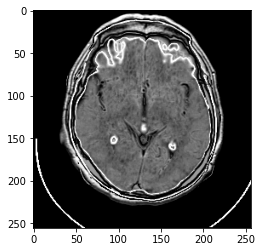

In [4]:
#imwrite("fusion", fused_image.astype('uint8'))
plt.imshow(fused_image, cmap='gray')

In [5]:
images_path = ['images/MRI-CT/ct.png', 'images/MRI-CT/mr.png']
output = 'results/T1-T2/'

# Read images
images = []
input_images = []
for image in images_path:
    images.append(imread(image, 0))

In [12]:
import numpy as np
from math import exp, pi
from scipy.ndimage import gaussian_filter
from cv2 import KAZE_DIFF_PM_G1, KAZE_DIFF_PM_G2, cartToPolar, Sobel, CV_32F
GAMMA1 = 1
GAMMA2 = 1
EPS = np.finfo(float).eps
K1 = -10
K2 = -20
DELTA1 = 0.5
DELTA2 = 0.75
L = 1
def _sobel_edge_detection(image, verbose=False):
    #gx = convolution(image, filter)
    sx = Sobel(image, CV_32F, 1, 0)
    sy = Sobel(image, CV_32F, 0, 1)

    if verbose:
        plt.imshow(sx, cmap='gray')
        plt.title("Horizontal Edge")
        plt.show()

        plt.imshow(sy, cmap='gray')
        plt.title("Vertical Edge")
        plt.show()

    return cartToPolar(sx, sy)

def _strenght_n_orientation(image):
    #The first input is the source image, which we convert to float. 
    #The second input is the output image, but we'll set that to None as we want the function 
    # call to return that for us. 
    #The third and fourth parameters specify the minimum and maximum values 
    # you want to appear in the output, which is 0 and 1 respectively, 
    #and the last output specifies how you want to normalize the image.
    # What I described falls under the NORM_MINMAX flag.
    #image = normalize(image.astype('float'), None, 0.0, 1.0, NORM_MINMAX)  
    # Kernels for convolving over the images
    #flt1= [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
    #flt2= [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
    # 1) get the map Sobel operator
    #fuseX = filter2D(image, -1, flt1)
    #fuseY = filter2D(image, -1, flt2)
    #   EQUIVALENT TO:
    s_x, s_y = _sobel_edge_detection(image)
    #fusex
    # A Sobel edge operator is applied to yield the edge strength G
    g = np.sqrt(s_x**2 + s_y**2)
    # Orientation α(n,m) information for each pixel p
    alpha = np.arctan(s_y / ( s_x + EPS))
    return (g, alpha)

def _perceptual_loss(gA, gF, alphaA, alphaF):
    # If g o alpha are followed by an underscore are ment to be considered written in uppercase
    # The relative strength and orientation values of g_AF(n,m) and alpha_AF(n,m) of an input 
    # image A with respect to F are formed as:
    if (sum( sum (gA )) > sum( sum( gF ))):
        g_AF = gF / (gA + EPS)
    else:
        g_AF = gA / (gF + EPS)
    
    alpha_AF = np.abs( np.abs(alphaA - alphaF) - pi/2) / (pi/2)

    qG_AF = GAMMA1 * np.linalg.inv(1 + exp( K1 *(g_AF - DELTA1)))
    qalpha_AF = GAMMA2 * np.linalg.inv(1 + exp( K2 *(alpha_AF - DELTA2) ))
    # These are used to derive the edge strength and orientation preservation values
    # QgAF(n,m)  and  QαAF(n,m)  model  perceptual  loss  of  information  in  F,  in  terms  of  
    # how well the strength and orientation values of a pixel p(n,m) in A are 
    # represented in the fused image. 
    #
    # Edge  information preservation values are then defined as
    q_AF = qG_AF * qalpha_AF
    # with  0  ≤  Q AF(n,m)  ≤  1 .  A  value  of  0  corresponds  to  the  complete  loss  of  edge  
    # information, at location (n,m), as transferred from A into F. QAF(n,m)=1 indicates 
    # “fusion” from A to F with no loss of information. 
    return q_AF

def xydeas_petrovic_metric(image1, image2, fusedImage):
    # EDGE Strenght and orientation for each pixels of the input images
    gA, alphaA = _strenght_n_orientation(image1)
    gB, alphaB = _strenght_n_orientation(image2)
    gF, alphaF = _strenght_n_orientation(fusedImage)
    
    q_AF = _perceptual_loss(gA, gF, alphaA, alphaF)
    q_BF = _perceptual_loss(gB, gF, alphaB, alphaF)
    #
    # In general edge preservation values which 
    # correspond to pixels with high edge strength, should influence normalised weighted  
    # performance metric QP more than 
    # those of relatively low edge strength.Thus, wA(n,m)=[gA(n,m)]^L and 
    # wB(n,m)=[gB(n,m)]^L where L is a constant.
    #
    wA = np.linalg.matrix_power(gA, L)
    wB = np.linalg.matrix_power(gB, L)
    # normalised weighted performance metric QP
    qP_ABF = sum( sum((q_AF * wA + q_BF * wB))) / sum ( sum((wA + wB)))
    return qP_ABF

In [19]:
#xydeas_petrovic_metric(images[0], images[1], fused_image) 
gA, alphaA = _strenght_n_orientation(images[0])
gF, alphaF = _strenght_n_orientation(fused_image)
#q_AF = _perceptual_loss(gA, gF, alphaA, alphaF)
#q_AF.shape
alpha_AF = np.abs( np.abs(alphaA - alphaF) - pi/2) / (pi/2)
g_AF = gF / (gA + EPS)
qG_AF = GAMMA1 / (1 + np.exp( K1 *(g_AF - DELTA1)))
qalpha_AF = GAMMA2 / (1 + exp( K2 *(alpha_AF - DELTA2) ))

LinAlgError: Singular matrix